In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
from tensorflow import keras
import pandas as pd
import seaborn as sns

import sys, os 
path = os.path.abspath("..")
sys.path.append(path)    
 
from training_utils import *

In [6]:
dataset = load_datasets("../datasets")
figure_dir = "plots"
fmt = "pdf"
with gzip.open("para.pkl.gz","r+b") as f:
        dic = pickle.load(f)

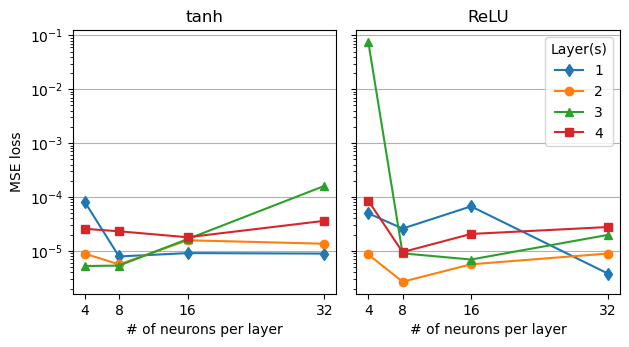

In [7]:

x_dict = {4:0, 8:1, 16:2, 32:3}
x = [4,8,16,32]
y_tanh = np.zeros((4,4))
y_relu = np.zeros((4,4))

for k,v in dic["para1"]["history"].items():
    paras = k.split("_")
    arr = y_tanh
    if paras[0] == "relu":
        arr = y_relu
    l = int(paras[1])
    n = int(paras[2])
    arr[l-1, x_dict[n]] = np.min(v["loss"])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True,subplot_kw=dict(box_aspect=1, xlabel="# of neurons per layer", xticks=x, yscale="log"))
markers = ["d", "o", "^", "s"]
ax1.set_title("tanh")
for i in range(len(y_tanh)):
    ax1.plot(x, y_tanh[i], marker=markers[i], label=f"{i+1}")

ax1.grid(axis='y')
ax1.set_ylabel("MSE loss")
ax1.set_axisbelow(True)


ax2.set_title("ReLU")
for i in range(len(y_relu)):
    plt.plot(x, y_relu[i], marker=markers[i], label=f"{i+1}")
ax2.legend(title="Layer(s)")
ax2.grid(axis='y')
ax2.set_axisbelow(True)


fig.tight_layout()
fig.savefig(f"{figure_dir}/para1_net.{fmt}", bbox_inches="tight")

plt.show()

In [8]:
para1 = dic["para1"]
model1 = para1["models"]["relu_2_8"]
X_norms1 = para1["X_norms"]
Y_norms1 = para1["Y_norms"]

value_dict = {"4-45":"tab:blue", "4-HV":"tab:red", "1-HV":"tab:green", "1-22p5":"tab:orange"}
df1 = evaluate_model(model1, dataset, X_norms1, Y_norms1)

2023-06-16 15:49:33.706354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


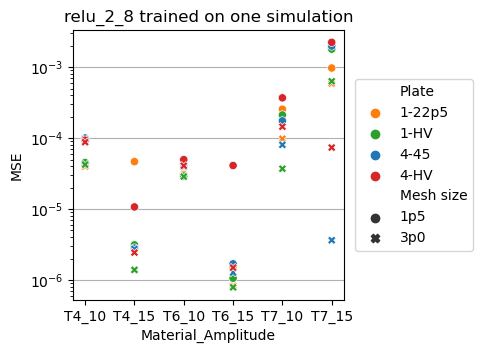

In [9]:
ax1 = sns.scatterplot(data=df1, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict, style="Mesh size")
ax1.set_axisbelow(True)
ax1.grid(axis='y')
ax1.semilogy()
ax1.set_title("relu_2_8 trained on one simulation")
fig = ax1.get_figure()
fig.set_figwidth(3.5)
fig.set_figheight(3.5)
ax1.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.savefig(f"{figure_dir}/para1_all.{fmt}",bbox_inches="tight")
plt.show()

1/1 [==============================] - 0s 29ms/step


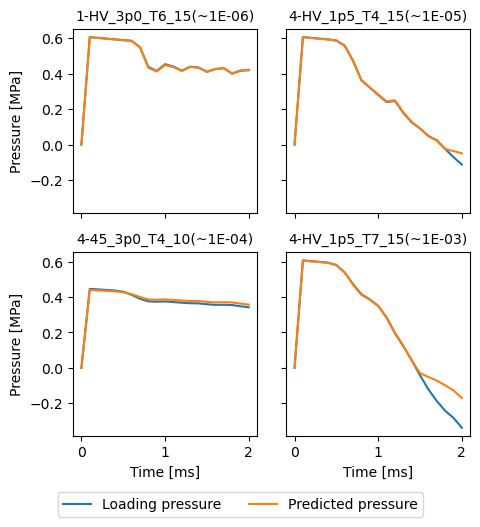

In [37]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(5,5),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1))
axs = [ax1,ax2,ax3,ax4]
names = ["1-HV_3p0_T6_15","4-HV_1p5_T4_15","4-45_3p0_T4_10","4-HV_1p5_T7_15"]

for name,ax,e in zip(names,axs,range(4)):
    db = dataset[name]
    PLAG = db["PLAG"][:-1]
    P = db["P"][:-1]
    N = db["N"][:-1]
    labels = db["labels"]
    lagp = np.ones_like(P)
    for i in range(len(lagp)):
        lagp[i] *= PLAG[i,1]

    lagp /= X_norms1[0]
    N /= X_norms1[1]
    P /= Y_norms1[0]

    nsteps = P.shape[0]
    nels = P.shape[1]
    errors = np.zeros_like(labels)
    X = np.transpose([lagp , N])
    Y = np.transpose([P])

    Y_shape = Y.shape
    prediction = model1.predict(X.reshape((Y_shape[0]*Y_shape[1],2)), batch_size=Y_shape[0]*Y_shape[1]).reshape(Y_shape)
    error = Y - prediction

    errors = np.zeros(nels)
    for i in range(nels):
        errors[i] = np.dot(error[i,:,0], error[i,:,0])/nels
    eid = errors.argmax()

    ax.set_title(f"{name}" + f"(~1E-0{6-e})")
    ax.plot(PLAG[:,0]*1000, P[:,eid]*Y_norms1[0], label="Loading pressure")
    ax.plot(PLAG[:,0]*1000, prediction[eid,:,0]*Y_norms1[0], label="Predicted pressure")
    #plt.plot(PLAG[:,0],N[:,eid], label="N")
    #ax.legend()
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Pressure [MPa]")
    ax.label_outer()
    ax.title.set_size(10)

fig.legend(labels=["Loading pressure", "Predicted pressure"], loc='center', bbox_to_anchor=(0.5, -0.02), ncol=2)

fig.tight_layout()  
fig.savefig(f"{figure_dir}/para1_test.{fmt}",bbox_inches="tight")
plt.show()

In [11]:
para2 = dic["para2"]
model2 = para2["model"]
X_norms2 = para2["X_norms"]
Y_norms2 = para2["Y_norms"]

df2 = evaluate_model(model2, dataset, X_norms2, Y_norms2)

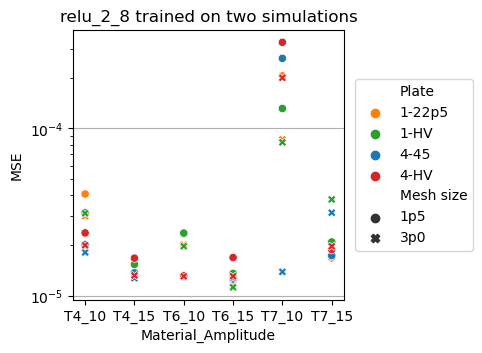

In [28]:
ax = sns.scatterplot(data=df2, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict, style="Mesh size")

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.semilogy()
ax.set_title("relu_2_8 trained on two simulations")
fig = ax.get_figure()
fig.set_figwidth(3.5)
fig.set_figheight(3.5)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.savefig(f"{figure_dir}/para2_all.{fmt}",bbox_inches="tight")
plt.show()

In [13]:
para3 = dic["para3"]
model3 = para3["model"]
X_norms3 = para3["X_norms"]
Y_norms3 = para3["Y_norms"]

df3 = evaluate_model(model3, dataset, X_norms3, Y_norms3)

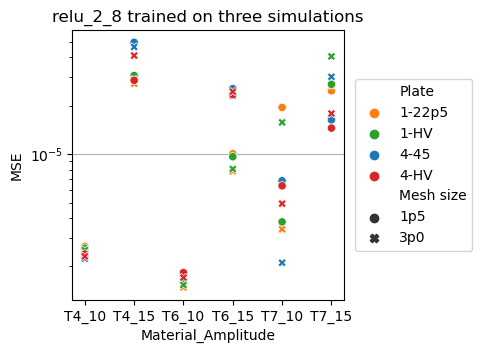

In [14]:
ax = sns.scatterplot(data=df3, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict, style="Mesh size")

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.semilogy()
ax.set_title("relu_2_8 trained on three simulations")
fig = ax.get_figure()
fig.set_figwidth(3.5)
fig.set_figheight(3.5)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.savefig(f"{figure_dir}/para3_all.{fmt}",bbox_inches="tight")
plt.show()

1/1 [==============================] - 0s 33ms/step


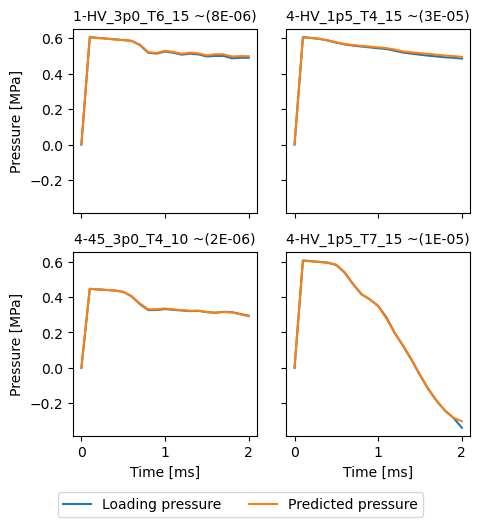

In [39]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(5,5),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1))
axs = [ax1,ax2,ax3,ax4]
names = ["1-HV_3p0_T6_15","4-HV_1p5_T4_15","4-45_3p0_T4_10","4-HV_1p5_T7_15"]

for name,ax,e in zip(names,axs,range(4)):
    db = dataset[name]
    PLAG = db["PLAG"][:-1]
    P = db["P"][:-1]
    N = db["N"][:-1]
    labels = db["labels"]
    lagp = np.ones_like(P)
    for i in range(len(lagp)):
        lagp[i] *= PLAG[i,1]

    lagp /= X_norms3[0]
    N /= X_norms3[1]
    P /= Y_norms3[0]

    nsteps = P.shape[0]
    nels = P.shape[1]
    errors = np.zeros_like(labels)
    X = np.transpose([lagp , N])
    Y = np.transpose([P])

    Y_shape = Y.shape
    prediction = model3.predict(X.reshape((Y_shape[0]*Y_shape[1],2)), batch_size=Y_shape[0]*Y_shape[1]).reshape(Y_shape)
    error = Y - prediction

    errors = np.zeros(nels)
    for i in range(nels):
        errors[i] = np.dot(error[i,:,0], error[i,:,0])/nels
    eid = errors.argmax()
    val = df3[df3["Job"]==name]["MSE"].max()
    ax.set_title(f"{name} ~" + f"({val:.0E})")
    ax.plot(PLAG[:,0]*1000, P[:,eid]*Y_norms3[0], label="Loading pressure")
    ax.plot(PLAG[:,0]*1000, prediction[eid,:,0]*Y_norms3[0], label="Predicted pressure")
    #plt.plot(PLAG[:,0],N[:,eid], label="N")
    #ax.legend()
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Pressure [MPa]")
    ax.label_outer()
    ax.title.set_size(10)
fig.legend(labels=["Loading pressure", "Predicted pressure"], loc='center', bbox_to_anchor=(0.5, -0.02), ncol=2)

fig.tight_layout()  
fig.savefig(f"{figure_dir}/para3_test.{fmt}",bbox_inches="tight")
plt.show()

In [16]:
para4= dic["para4"]
model4 = para4["model"]
X_norms4 = para4["X_norms"]
Y_norms4 = para4["Y_norms"]

df4 = evaluate_model(model4, dataset, X_norms4, Y_norms4)

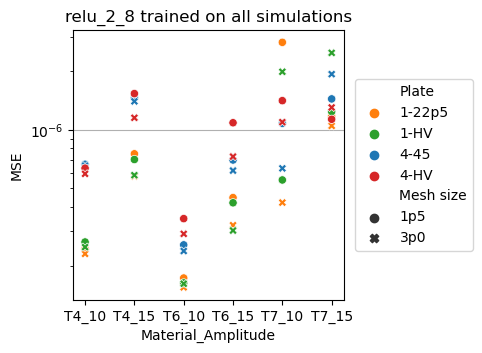

In [17]:
ax = sns.scatterplot(data=df4, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict, style="Mesh size")

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.semilogy()
ax.set_title("relu_2_8 trained on all simulations")
fig = ax.get_figure()
fig.set_figwidth(3.5)
fig.set_figheight(3.5)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.savefig(f"{figure_dir}/para4_all.{fmt}",bbox_inches="tight")
plt.show()

1/1 [==============================] - 0s 31ms/step


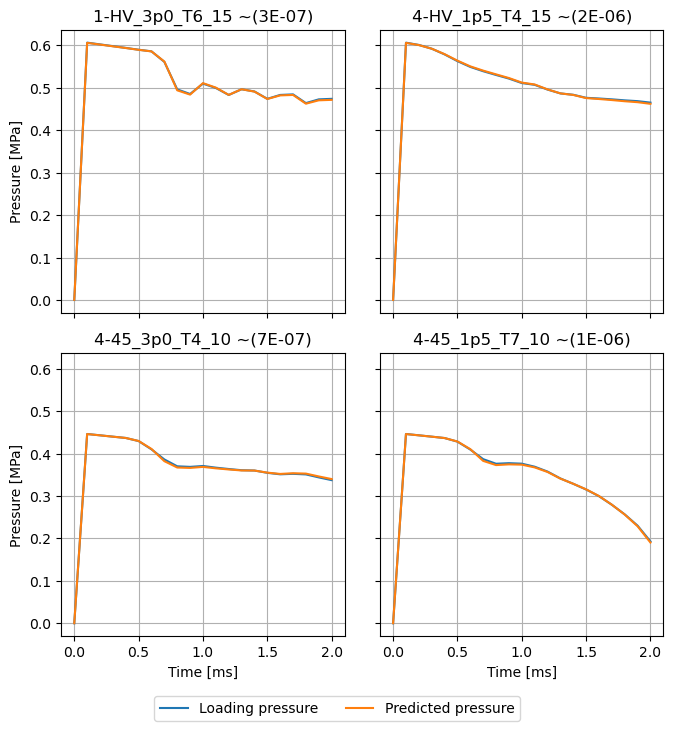

In [18]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(7,7),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1))
axs = [ax1,ax2,ax3,ax4]
names = ["1-HV_3p0_T6_15","4-HV_1p5_T4_15","4-45_3p0_T4_10","4-45_1p5_T7_10"]

for name,ax,e in zip(names,axs,range(4)):
    db = dataset[name]
    PLAG = db["PLAG"][:-1]
    P = db["P"][:-1]
    N = db["N"][:-1]
    labels = db["labels"]
    lagp = np.ones_like(P)
    for i in range(len(lagp)):
        lagp[i] *= PLAG[i,1]

    lagp /= X_norms4[0]
    N /= X_norms4[1]
    P /= Y_norms4[0]

    nsteps = P.shape[0]
    nels = P.shape[1]
    errors = np.zeros_like(labels)
    X = np.transpose([lagp , N])
    Y = np.transpose([P])

    Y_shape = Y.shape
    prediction = model4.predict(X.reshape((Y_shape[0]*Y_shape[1],2)), batch_size=Y_shape[0]*Y_shape[1]).reshape(Y_shape)
    error = Y - prediction

    errors = np.zeros(nels)
    for i in range(nels):
        errors[i] = np.dot(error[i,:,0], error[i,:,0])/nels
    eid = errors.argmax()

    val = df4[df4["Job"]==name]["MSE"].max()
    ax.set_title(f"{name} ~" + f"({val:.0E})")
    ax.plot(PLAG[:,0]*1000, P[:,eid]*Y_norms4[0], label="Loading pressure")
    ax.plot(PLAG[:,0]*1000, prediction[eid,:,0]*Y_norms4[0], label="Predicted pressure")
    #plt.plot(PLAG[:,0],N[:,eid], label="N")
    #ax.legend()
    ax.grid(axis="both")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Pressure [MPa]")
    ax.label_outer()
fig.legend(labels=["Loading pressure", "Predicted pressure"], loc='center', bbox_to_anchor=(0.5, -0.02), ncol=2)

fig.tight_layout()  
fig.savefig(f"{figure_dir}/para4_test.{fmt}",bbox_inches="tight")
plt.show()

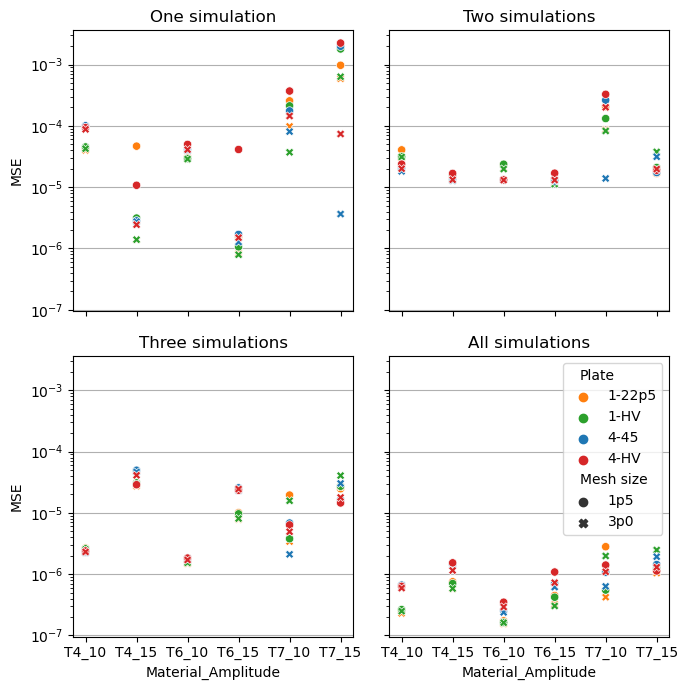

In [19]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(7,7),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1, yscale="log"))
sns.scatterplot(ax=ax1, data=df1, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size", legend=None)
sns.scatterplot(ax=ax2, data=df2, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size", legend=None)
sns.scatterplot(ax=ax3, data=df3, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size", legend=None)
sns.scatterplot(ax=ax4, data=df4, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")

axs = [ax1,ax2,ax3,ax4]
titles = ["One simulation", "Two simulations", "Three simulations", "All simulations"]

for ax,title in zip(axs,titles):
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    ax.set_title(title)

fig.tight_layout()
fig.savefig(f"{figure_dir}/para_all.{fmt}",bbox_inches="tight")
plt.show()

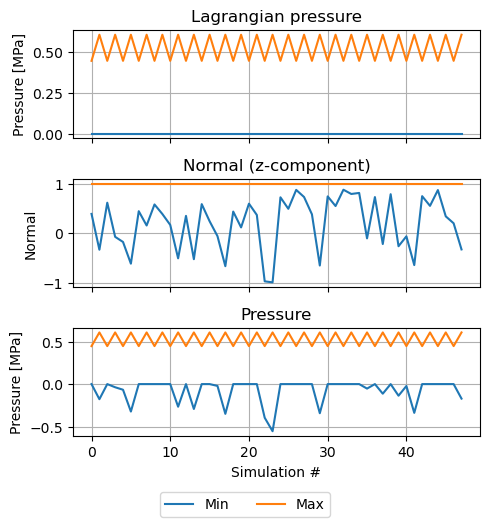

['1-HV_3p0_T7_15' '1-HV_3p0_T7_10' '1-HV_1p5_T7_15' '4-45_1p5_T7_15'
 '4-HV_1p5_T7_15' '1-22p5_1p5_T7_15' '1-HV_1p5_T4_15' '1-22p5_3p0_T7_15'
 '1-22p5_1p5_T4_15' '4-HV_3p0_T7_15' '4-HV_1p5_T6_15' '4-HV_1p5_T4_15'
 '1-22p5_1p5_T7_10' '4-45_3p0_T7_15' '1-22p5_1p5_T6_15' '4-HV_1p5_T7_10'
 '1-HV_1p5_T7_10' '1-HV_3p0_T4_15' '1-22p5_3p0_T4_15' '1-22p5_3p0_T7_10']


In [42]:
plags = np.zeros((48,2))
ps = np.zeros((48,2))
ns = np.zeros((48,2))
jobnames = list()

for i,(jobname,job) in enumerate(dataset.items()):
    jobnames.append(jobname)
    plag = job["PLAG"][:-1]
    n = job["N"][:-1]
    p = job["P"][:-1]
    plags[i] = [plag[:,1].min(), plag[:,1].max()]
    ps[i] = [p.min(), p.max()]
    ns[i] = [n.min(), n.max()]

variables = ["Lagrangian pressure", "Normal (z-component)", "Pressure"]
values = [plags,ns, ps]
ylabels = ["Pressure [MPa]", "Normal", "Pressure [MPa]"]
fig, ((ax1),(ax2), (ax3)) = plt.subplots(3,1, figsize=(5,5), sharex=True)
axs = [ax1,ax2,ax3]

for va,val, ax, ylabel in zip(variables,values,axs,ylabels):

    ax.set_title(va)
    ax.plot(val[:,0], label="Min")
    ax.plot(val[:,1], label="Max")
    ax.set_xlabel("Simulation #")
    ax.set_ylabel(ylabel)
    ax.label_outer()
    ax.grid()

fig.tight_layout()
fig.legend(labels=["Min", "Max"], loc='center', bbox_to_anchor=(0.5, -0.02), ncol=2)
fig.savefig(f"{figure_dir}/vars.{fmt}", bbox_inches="tight")
plt.show()
print(np.array(jobnames)[ns[:,0].argsort()[:20]])

In [21]:
para5 = dic["para5"]
model5 = para5["model"]
X_norms5 = para5["X_norms"]
Y_norms5 = para5["Y_norms"]

df5 = evaluate_model(model5, dataset, para5["X_norms"], para5["Y_norms"])

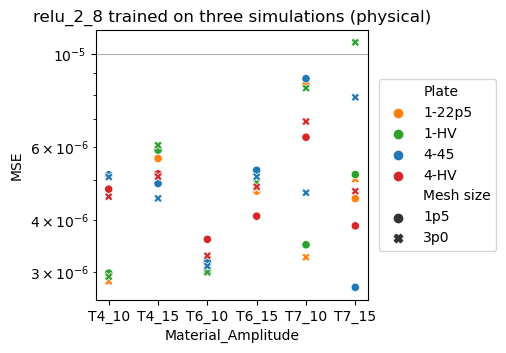

In [22]:
ax = sns.scatterplot(data=df5, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict, style="Mesh size")

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.semilogy()
ax.set_title("relu_2_8 trained on three simulations (physical)")
fig = ax.get_figure()
fig.set_figwidth(3.5)
fig.set_figheight(3.5)
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.savefig(f"{figure_dir}/para5_all.{fmt}", bbox_inches="tight")
plt.show()

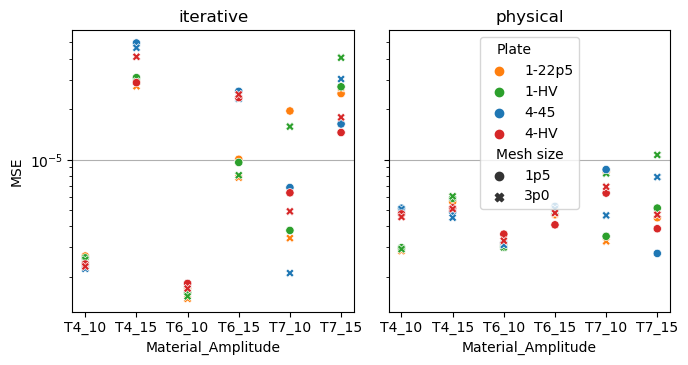

In [50]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,4),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1, yscale="log"))
ax1 = sns.scatterplot(ax=ax1,data=df3, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size", legend=None)
ax2 = sns.scatterplot(ax=ax2,data=df5, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")

axs = [ax1,ax2]
titles = ["iterative", "physical"]

for ax,title in zip(axs,titles):
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    ax.set_title(title)
fig.tight_layout()

fig.savefig(f"{figure_dir}/para3_vs_para5.{fmt}", bbox_inches="tight")
plt.show()

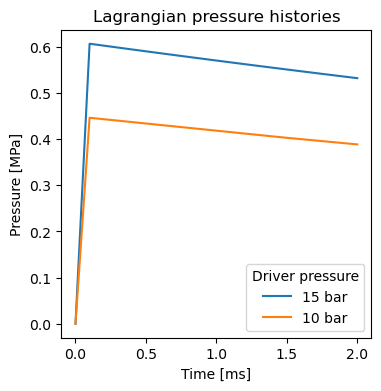

In [24]:
dat10 = dataset["1-22p5_1p5_T4_10"]["PLAG"][:-1]
dat15 = dataset["1-22p5_1p5_T4_15"]["PLAG"][:-1]

fig = plt.figure(figsize=(4,4))
plt.title("Lagrangian pressure histories")
plt.plot(dat15[:,0]*1000, dat15[:,1], label="15 bar")
plt.plot(dat10[:,0]*1000, dat10[:,1], label="10 bar")
plt.legend(title="Driver pressure")
plt.xlabel("Time [ms]")
plt.ylabel("Pressure [MPa]")
fig.savefig(f"{figure_dir}/pressures.{fmt}", bbox_inches="tight")
plt.show(fig)

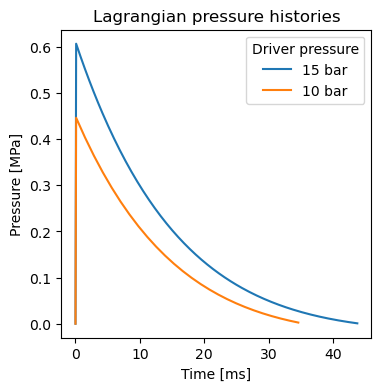

In [25]:
l10 = [ 0.,0., 0.0001, 0.4462, 0.00147931034482759, 0.403353179334616, 0.00285862068965517, 0.364021421197428,0.00423793103448276, 0.327938361800707, 0.00561724137931035, 0.294856876200396, 0.00699655172413793, 0.264547732713157, 0.00837586206896552, 0.236798339297337,0.0097551724137931, 0.211411575720852, 0.0111344827586207, 0.188204705748233, 0.0125137931034483, 0.167008363961625, 0.0138931034482759, 0.147665612187893,0.0152724137931034, 0.130031060837949, 0.016651724137931, 0.113970050776412, 0.0180310344827586, 0.0993578916312382, 0.0194103448275862, 0.0860791527252794,0.0207896551724138, 0.0740270030661679, 0.0221689655172414, 0.0631025970685725, 0.023548275862069, 0.0532145029048911, 0.0249275862068966, 0.0442781705878096,0.0263068965517241, 0.0362154370818443, 0.0276862068965517, 0.0289540659218805, 0.0290655172413793, 0.0224273189856682, 0.0304448275862069, 0.0165735582250075,0.0318241379310345, 0.0113358753076885, 0.0332034482758621, 0.00666174725982981, 0.0345827586206897, 0.00250271632671636]
l15 = [0.,0.,0.0001,0.6066, 0.000326130653266332, 0.597255606871735, 0.000552261306532663, 0.588039538224459,0.000778391959798995, 0.578950140015279, 0.00100452261306533, 0.569985778680351, 0.00123065326633166, 0.561144840888287, 0.00145678391959799, 0.552425733296464,0.00168291457286432, 0.543826882310219, 0.00190904522613065, 0.535346733844879, 0.00213517587939699, 0.526983753090603, 0.00236130653266332, 0.518736424279999,0.00258743718592965, 0.510603250458486, 0.00281356783919598, 0.502582753257369, 0.00303969849246231, 0.494673472669594, 0.00326582914572864, 0.486873966828152,0.00349195979899498, 0.479182811787102, 0.00371809045226131, 0.471598601305186, 0.00394422110552764, 0.464119946631993, 0.00417035175879397, 0.456745476296665,0.0043964824120603, 0.449473835899089, 0.00462261306532663, 0.442303687903566, 0.00484874371859297, 0.435233711434919, 0.0050748743718593, 0.428262602077018,0.00530100502512563, 0.421389071673683, 0.00552713567839196, 0.414611848131946, 0.00575326633165829, 0.407929675227649, 0.00597939698492462, 0.401341312413332,0.00620552763819096, 0.39484553462841, 0.00643165829145729, 0.388441132111588, 0.00665778894472362, 0.382126910215507, 0.00688391959798995, 0.375901689223581,0.00711005025125628, 0.369764304169008, 0.00733618090452261, 0.363713604655925, 0.00756231155778894, 0.357748454682691, 0.00778844221105528, 0.351867732467255,0.00801457286432161, 0.346070330274603, 0.00824070351758794, 0.340355154246253, 0.00846683417085427, 0.334721124231771, 0.0086929648241206, 0.329167173622288,0.00891909547738693, 0.323692249185992, 0.00914522613065327, 0.318295310905579, 0.0093713567839196, 0.312975331817627, 0.00959748743718593, 0.307731297853887,0.00982361809045226, 0.302562207684454, 0.0100497487437186, 0.2974670725628, 0.0102758793969849, 0.292444916172661, 0.0105020100502513, 0.287494774476728,0.0107281407035176, 0.282615695567152, 0.0109542713567839, 0.277806739517819, 0.0111804020100503, 0.273066978238387, 0.0114065326633166, 0.268395495330055,0.0116326633165829, 0.263791385943056, 0.0118587939698492, 0.259253756635837, 0.0120849246231156, 0.254781725235929, 0.0123110552763819, 0.250374420702459,0.0125371859296482, 0.246030982990315, 0.0127633165829146, 0.241750562915915, 0.0129894472361809, 0.237532322024587, 0.0132155778894472, 0.233375432459526,0.0134417085427136, 0.229279076832312, 0.0136678391959799, 0.225242448094972, 0.0138939698492462, 0.221264749413574, 0.0141201005025126, 0.217345194043321,0.0143462311557789, 0.213483005205142, 0.0145723618090452, 0.209677415963749, 0.0147984924623116, 0.20592766910716, 0.0150246231155779, 0.202233017027652,0.0152507537688442, 0.198592721604139, 0.0154768844221106, 0.195006054085953, 0.0157030150753769, 0.191472294978023, 0.0159291457286432, 0.187990733927409,0.0161552763819096, 0.184560669611211, 0.0163814070351759, 0.181181409625806, 0.0166075376884422, 0.177852270377416, 0.0168336683417085, 0.174572576973979,0.0170597989949749, 0.171341663118321, 0.0172859296482412, 0.168158871002604, 0.0175120603015075, 0.165023551204031, 0.0177381909547739, 0.161935062581814,0.0179643216080402, 0.15889277217536, 0.0181904522613065, 0.155896055103688, 0.0184165829145729, 0.152944294466046, 0.0186427135678392, 0.150036881243721,0.0188688442211055, 0.147173214203024, 0.0190949748743719, 0.144352699799443, 0.0193211055276382, 0.141574752082938, 0.0195472361809045, 0.138838792604378,0.0197733668341709, 0.136144250323099, 0.0199994974874372, 0.133490561515573, 0.0202256281407035, 0.130877169685166, 0.0204517587939699, 0.128303525472992,0.0206778894472362, 0.125769086569826, 0.0209040201005025, 0.123273317629081, 0.0211301507537688, 0.120815690180833, 0.0213562814070352, 0.118395682546868,0.0215824120603015, 0.116012779756769, 0.0218085427135678, 0.11366647346499, 0.0220346733668342, 0.111356261868947, 0.0222608040201005, 0.109081649628081,0.0224869346733668, 0.106842147783902, 0.0227130653266332, 0.104637273680993, 0.0229391959798995, 0.102466550888964, 0.0231653266331658, 0.100329509125348,0.0233914572864322, 0.0982256841794246, 0.0236175879396985, 0.0961546178369601, 0.0238437185929648, 0.0941158578058585, 0.0240698492462312, 0.092108957642704,0.0242959798994975, 0.0901334766801921, 0.0245221105527638, 0.0881889799554347, 0.0247482412060302, 0.0862750381391305, 0.0249743718592965, 0.0843912274655903,0.0252005025125628, 0.0825371296636056, 0.0254266331658292, 0.0807123318881533, 0.0256527638190955, 0.078916426652924, 0.0258788944723618, 0.0771490117636656,0.0261050251256281, 0.0754096902523324, 0.0263311557788945, 0.0736980703120296, 0.0265572864321608, 0.0720137652327443, 0.0267834170854271, 0.0703563933378536,0.0270095477386935, 0.0687255779214004, 0.0272356783919598, 0.0671209471861283, 0.0274618090452261, 0.0655421341822661, 0.0276879396984925, 0.0639887767470529,0.0279140703517588, 0.0624605174449957, 0.0281402010050251, 0.0609570035088507, 0.0283663316582915, 0.0594778867813188, 0.0285924623115578, 0.0580228236574478,0.0288185929648241, 0.0565914750277332, 0.0290447236180905, 0.0551835062219078, 0.0292708542713568, 0.0537985869534137, 0.0294969849246231, 0.0524363912645473,0.0297231155778895, 0.0510965974722701, 0.0299492462311558, 0.0497788881146768, 0.0301753768844221, 0.048482949898114, 0.0304015075376884, 0.0472084736449397,0.0306276381909548, 0.0459551542419185, 0.0308537688442211, 0.0447226905892433, 0.0310798994974874, 0.0435107855501762, 0.0313060301507538, 0.0423191459013017,0.0315321608040201, 0.0411474822833856, 0.0317582914572864, 0.03999550915283, 0.0319844221105528, 0.0388629447337202, 0.0322105527638191, 0.0377495109704547,0.0324366834170854, 0.0366549334809516, 0.0326628140703518, 0.0355789415104251, 0.0328889447236181, 0.0345212678857249, 0.0331150753768844, 0.0334816489702317,0.0333412060301508, 0.0324598246193025, 0.0335673366834171, 0.0314555381362592, 0.0337934673366834, 0.0304685362289133, 0.0340195979899498, 0.0294985689666215,0.0342457286432161, 0.0285453897378651, 0.0344718592964824, 0.0276087552083464, 0.0346979899497487, 0.0266884252795979, 0.0349241206030151, 0.0257841630480957,0.0351502512562814, 0.0248957347648732, 0.0353763819095477, 0.0240229097956276, 0.0356025125628141, 0.0231654605813146, 0.0358286432160804, 0.0223231625992243,0.0360547738693467, 0.0214957943245335, 0.0362809045226131, 0.0206831371923279, 0.0365070351758794, 0.0198849755600897, 0.0367331658291457, 0.0191010966706435,0.0369592964824121, 0.0183312906155567, 0.0371854271356784, 0.0175753502989876, 0.0374115577889447, 0.0168330714019766, 0.0376376884422111, 0.0161042523471749,0.0378638190954774, 0.015388694264006, 0.0380899497487437, 0.0146862009542538, 0.0383160804020101, 0.0139965788580732, 0.0385422110552764, 0.0133196370204177,0.0387683417085427, 0.012655187057879, 0.038994472361809, 0.0120030431259338, 0.0392206030150754, 0.0113630218865928, 0.0394467336683417, 0.0107349424764472,0.039672864321608, 0.0101186264751076, 0.0398989949748744, 0.00951389787403178, 0.0401251256281407, 0.00892058304573438, 0.040351256281407, 0.00833851071337684,0.0405773869346734, 0.00776751192073038, 0.0408035175879397, 0.00720742000250932, 0.041029648241206, 0.00665807055506956, 0.0412557788944724, 0.00611930140746779,0.0414819095477387, 0.00559095259287752, 0.041708040201005, 0.00507286632035721, 0.0419341708542714, 0.00456488694696666, 0.0421603015075377, 0.00406686095022704,0.042386432160804, 0.00357863690092094, 0.0426125628140704, 0.00310006543622792, 0.0428386934673367, 0.00263099923319176, 0.043064824120603, 0.00217129298251542,0.0432909547738693, 0.00172080336267967, 0.0435170854271357, 0.0012793890143815, 0.043743216080402, 0.000846910515288722]

l10 = np.array(l10)
l15 = np.array(l15)

fig = plt.figure(figsize=(4,4))
plt.title("Lagrangian pressure histories")
plt.plot(l15[::2]*1000, l15[1::2], label="15 bar")
plt.plot(l10[::2]*1000, l10[1::2], label="10 bar")
plt.legend(title="Driver pressure")
plt.xlabel("Time [ms]")
plt.ylabel("Pressure [MPa]")
fig.savefig(f"{figure_dir}/pressures_full.{fmt}", bbox_inches="tight")
plt.show(fig)

TypeError: '>=' not supported between instances of 'list' and 'int'

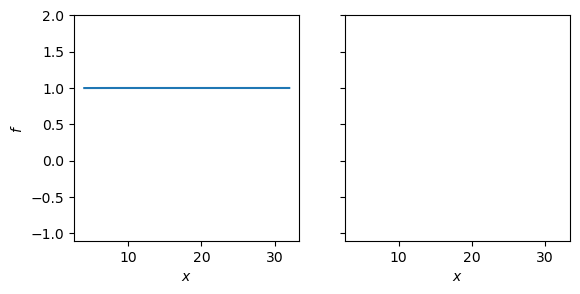

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, subplot_kw=dict(box_aspect=1, xlabel="$x$" , ylabel="$f$", ylim=(-1.1,2)))
ax1.plot(x,np.tanh(x), label="$f(x) = \mathrm{tanh}(x)$")
ax1.plot(x,np.where(x >= 0, x, np.zeros_like(x)), label="$f(x) = \mathrm{ReLU}(x)$")
ax1.legend()

ax2.plot(x,1/(1 + np.exp(-x)), label="$f(x) = \mathrm{sigmoid}(x)$", color="tab:green")
ax2.plot(x,x, label="$f(x) = \mathrm{linear}(x)$", color="tab:red")
ax2.legend()
fig.tight_layout()
fig.savefig(f"{figure_dir}/activations.{fmt}", bbox_inches="tight")
plt.show()

In [ ]:
para6 = dic["para6"]
model6 = para6["model"]
X_norms6 = para6["X_norms"]
Y_norms6 = para6["Y_norms"]

df6 = evaluate_model(model6, dataset, para6["X_norms"], para6["Y_norms"])

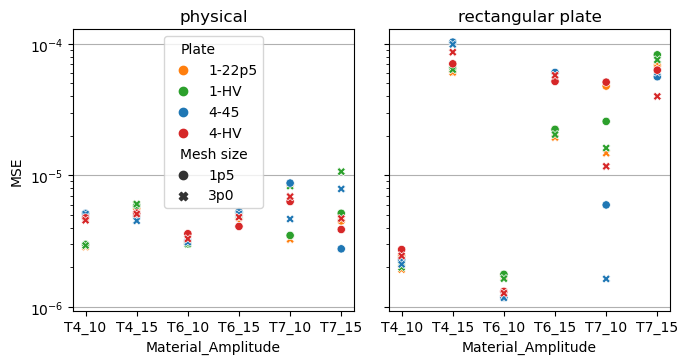

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,4),sharey=True, sharex=True,subplot_kw=dict(box_aspect=1, yscale="log"))
ax1 = sns.scatterplot(ax=ax1,data=df5, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size")
ax2 = sns.scatterplot(ax=ax2,data=df6, y="MSE", x="Material_Amplitude", hue="Plate", palette=value_dict,style="Mesh size", legend=None)

axs = [ax1,ax2]
titles = ["physical", "rectangular plate"]

for ax,title in zip(axs,titles):
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    ax.set_title(title)
fig.tight_layout()

fig.savefig(f"{figure_dir}/para5_vs_para6.{fmt}", bbox_inches="tight")
plt.show()